## Loading Libraries

In [35]:
import pandas as pd; pd.set_option('display.max_columns',100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

from matplotlib import pyplot as plt; plt.style.use('ggplot')
import seaborn as sns  
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline,Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier,GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

import optuna

In [9]:
original=pd.read_csv("Churn_Modelling.csv")
samaple_sub=pd.read_csv("sample_submission.csv")
test=pd.read_csv("test.csv")
train=pd.read_csv("train.csv")

In [36]:
train.dtypes

id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

In [37]:
for col in ["Age","HasCrCard","IsActiveMember"]:
    train[col]=train[col].astype(int)
    test[col]=test[col].astype(int)

In [38]:
train.dtypes

id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int32
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int32
IsActiveMember       int32
EstimatedSalary    float64
Exited               int64
dtype: object

In [13]:
original.head(8).T

,0,1,2,3,4,5,6,7
RowNumber,1,2,3,4,5,6,7,8
CustomerId,15634602,15647311,15619304,15701354,15737888,15574012,15592531,15656148
Surname,Hargrave,Hill,Onio,Boni,Mitchell,Chu,Bartlett,Obinna
CreditScore,619,608,502,699,850,645,822,376
Geography,France,Spain,France,France,Spain,Spain,NaN,Germany
Gender,Female,Female,Female,Female,Female,Male,Male,Female
Age,42.0,41.0,42.0,39.0,43.0,44.0,50.0,29.0
Tenure,2,1,8,1,2,8,7,4
Balance,0.0,83807.86,159660.8,0.0,125510.82,113755.78,0.0,115046.74
NumOfProducts,1,1,3,2,1,2,2,4


In [15]:
train.shape,original.shape,test.shape

((165034, 14), (10002, 14), (110023, 13))

In [19]:
original.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [22]:
train.nunique()

id                 165034
CustomerId          23221
Surname              2797
CreditScore           457
Geography               3
Gender                  2
Age                    71
Tenure                 11
Balance             30075
NumOfProducts           4
HasCrCard               2
IsActiveMember          2
EstimatedSalary     55298
Exited                  2
dtype: int64

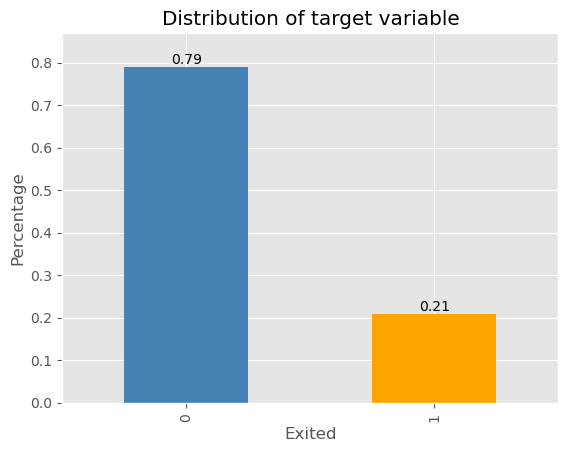

In [58]:
ax=round(train['Exited'].value_counts(normalize=True),2).plot(kind='bar',color=['steelblue','orange'])
ax.bar_label(ax.containers[0],label_type='edge',fontsize=10)
ax.margins(y=0.1)
plt.ylabel('Percentage');
plt.xlabel('Exited');
plt.title('Distribution of target variable');


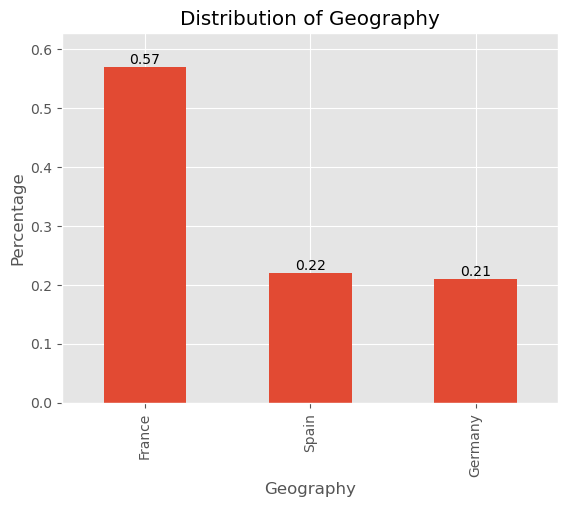

In [119]:
ax=round(train['Geography'].value_counts(normalize=True),2).plot(kind='bar')
ax.bar_label(ax.containers[0],label_type='edge',fontsize=10)
ax.margins(y=0.1)
plt.ylabel('Percentage');
plt.xlabel('Geography');
plt.title('Distribution of Geography');

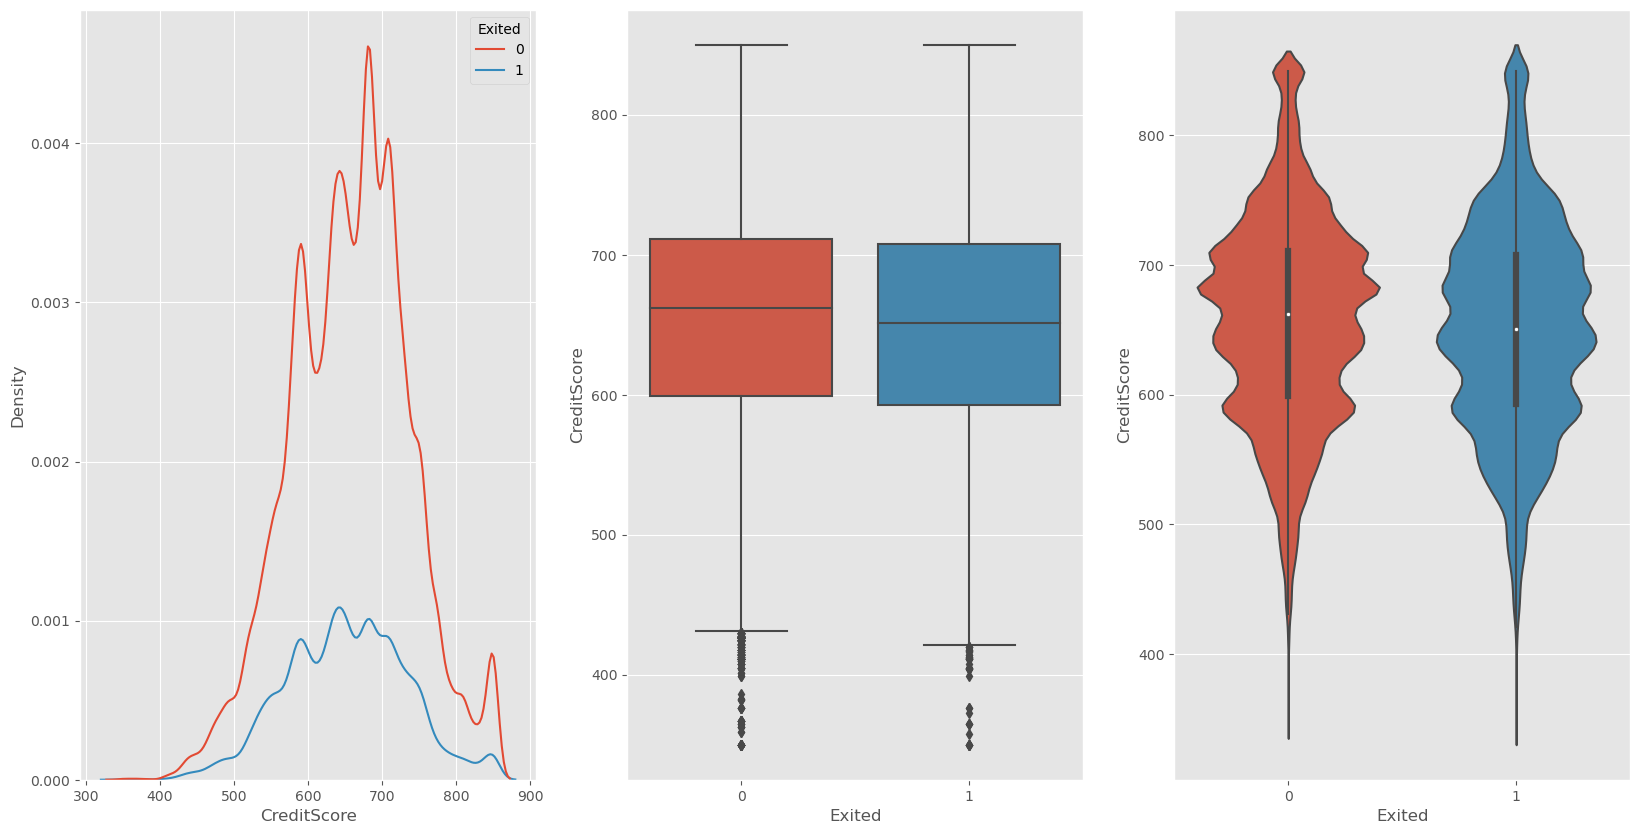

In [72]:
fig,axes=plt.subplots(1,3,figsize=(20,10))

sns.kdeplot(ax=axes[0],data=train,x='CreditScore',hue='Exited');
sns.boxplot(ax=axes[1],data=train,x='Exited',y='CreditScore');
sns.violinplot(ax=axes[2],data=train,x='Exited',y='CreditScore');

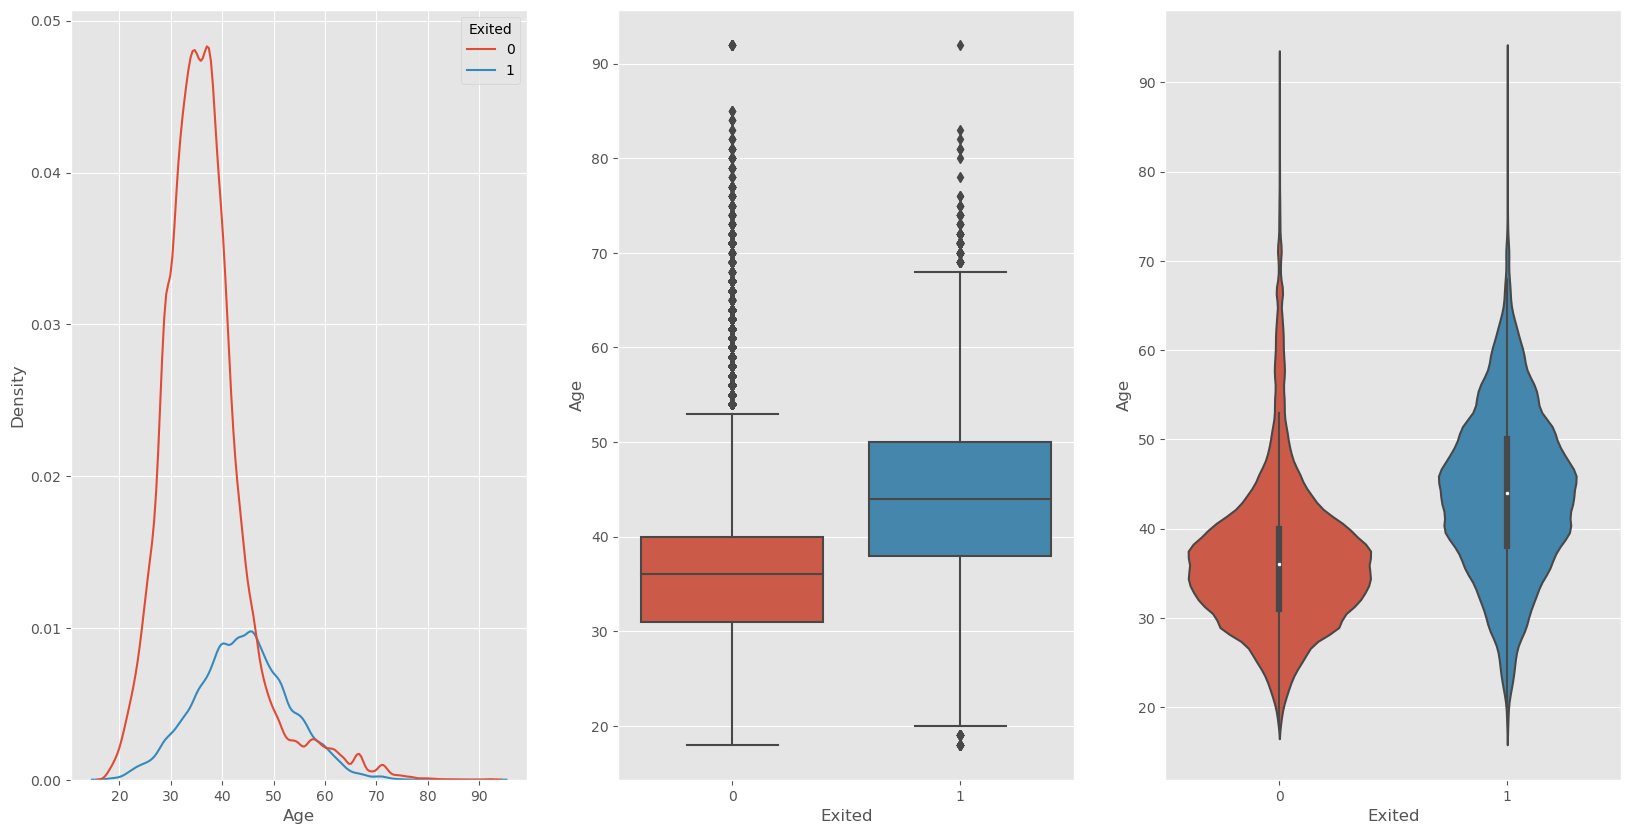

In [73]:
fig,axes=plt.subplots(1,3,figsize=(20,10))

sns.kdeplot(ax=axes[0],data=train,x='Age',hue='Exited');
sns.boxplot(ax=axes[1],data=train,x='Exited',y='Age');
sns.violinplot(ax=axes[2],data=train,x='Exited',y='Age');

In [75]:
# fig,axes=plt.subplots(1,3,figsize=(20,10))

# sns.kdeplot(ax=axes[0],data=train,x='Tenure',hue='Exited');
# sns.boxplot(ax=axes[1],data=train,x='Exited',y='Tenure');
# sns.violinplot(ax=axes[2],data=train,x='Exited',y='Tenure');

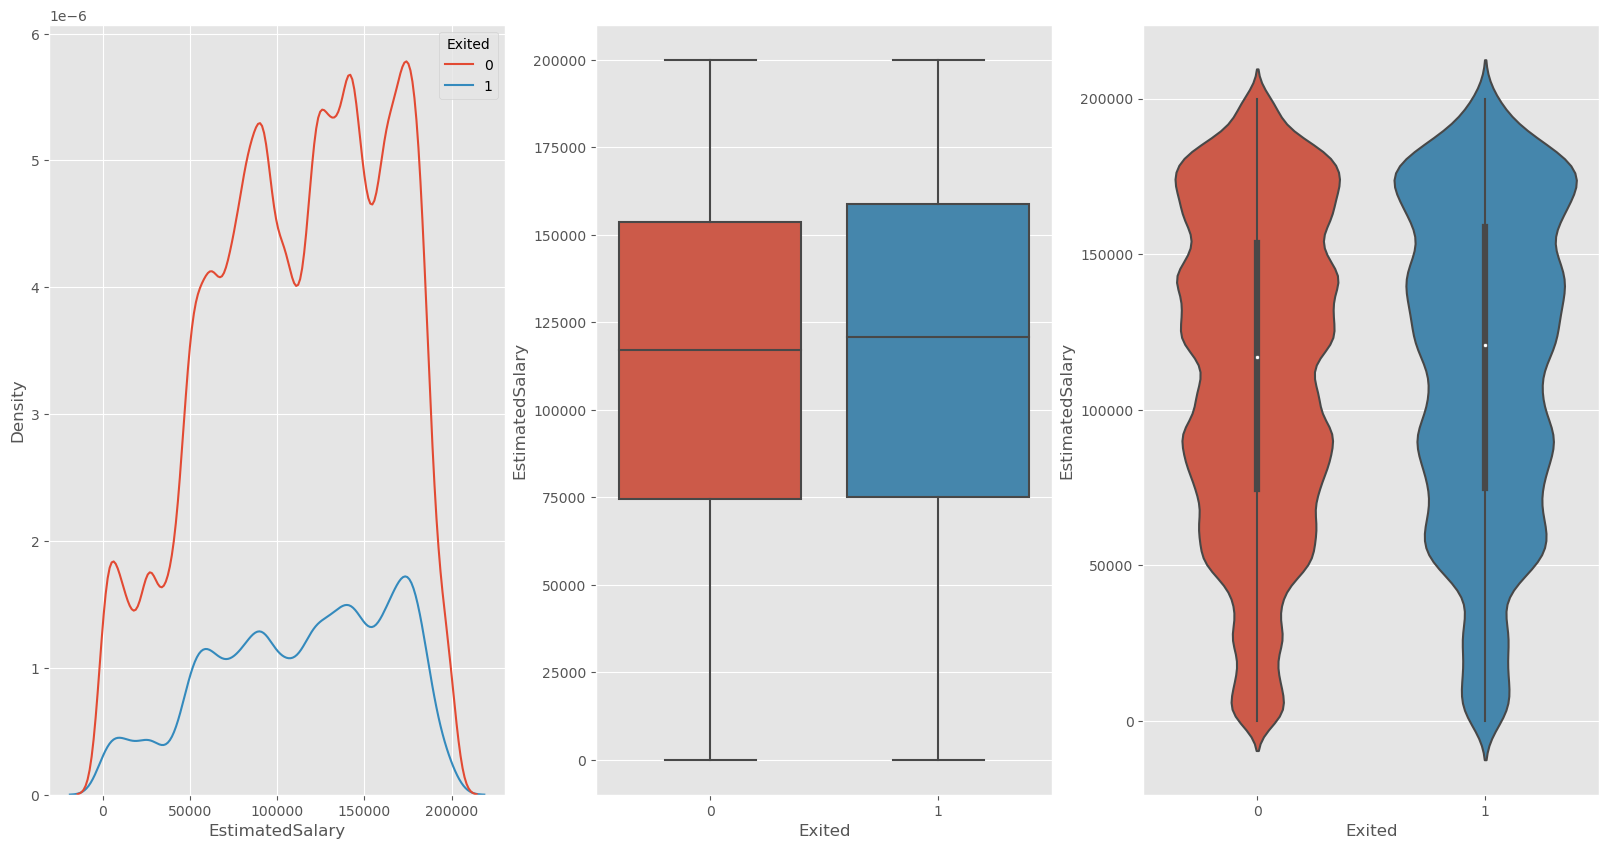

In [76]:
fig,axes=plt.subplots(1,3,figsize=(20,10))

sns.kdeplot(ax=axes[0],data=train,x='EstimatedSalary',hue='Exited');
sns.boxplot(ax=axes[1],data=train,x='Exited',y='EstimatedSalary');
sns.violinplot(ax=axes[2],data=train,x='Exited',y='EstimatedSalary');

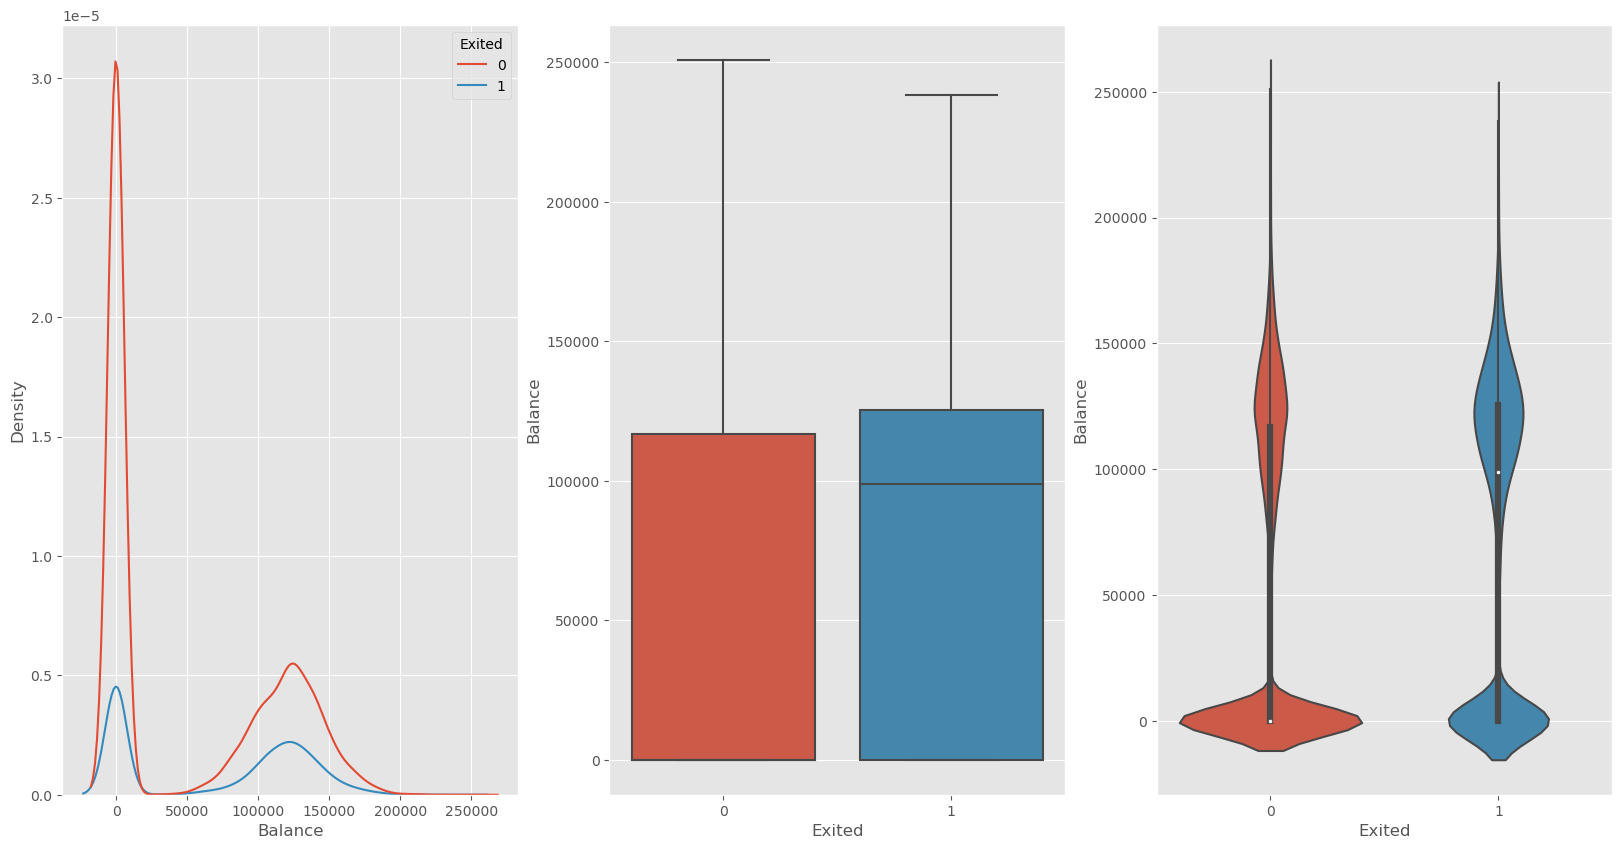

In [104]:
fig,axes=plt.subplots(1,3,figsize=(20,10))

sns.kdeplot(ax=axes[0],data=train,x='Balance',hue='Exited');
sns.boxplot(ax=axes[1],data=train,x='Exited',y='Balance');
sns.violinplot(ax=axes[2],data=train,x='Exited',y='Balance');

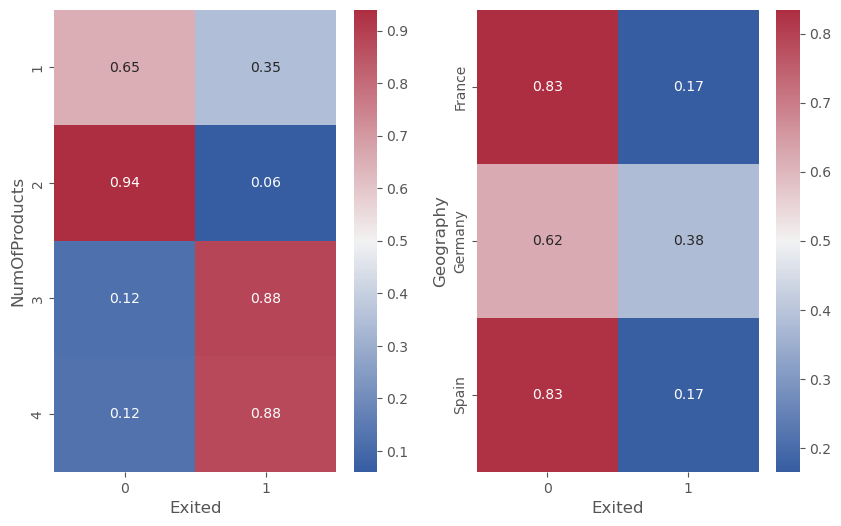

In [102]:
fig, axes = plt.subplots(1, 2, figsize = (10, 6))

cmap = sns.diverging_palette(255, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

sns.heatmap(ax = axes[0], data = pd.crosstab(train['NumOfProducts'], train['Exited'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');
sns.heatmap(ax = axes[1], data = pd.crosstab(train['Geography'], train['Exited'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');

In [81]:
pd.crosstab(train["NumOfProducts"],train["Exited"],normalize="index")

Exited,0,1
NumOfProducts,,
1,0.652881,0.347119
2,0.939578,0.060422
3,0.117484,0.882516
4,0.124211,0.875789


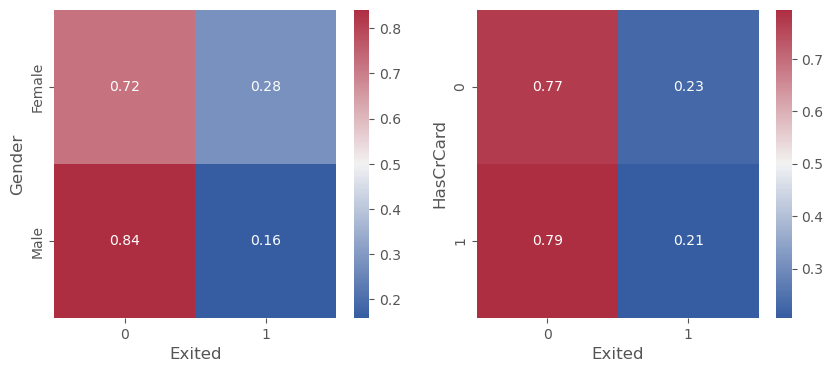

In [109]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

cmap = sns.diverging_palette(255, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

sns.heatmap(ax = axes[0], data = pd.crosstab(train['Gender'], train['Exited'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');
sns.heatmap(ax = axes[1], data = pd.crosstab(train['HasCrCard'], train['Exited'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');

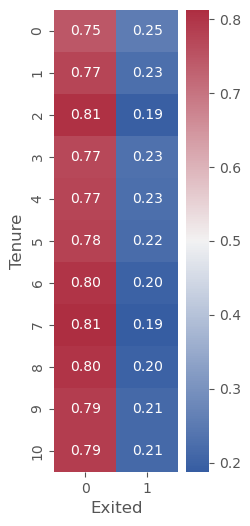

In [96]:
fig, ax = plt.subplots(1, 1, figsize = (2, 6))

cmap = sns.diverging_palette(255, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

sns.heatmap(ax = ax, data = pd.crosstab(train['Tenure'], train['Exited'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');


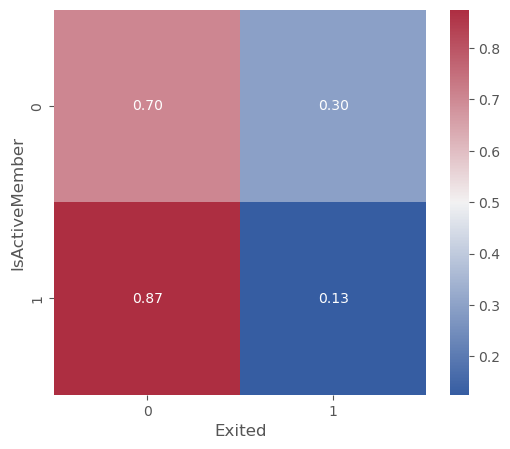

In [101]:
fig, ax = plt.subplots(1, 1, figsize = (6,5))

cmap = sns.diverging_palette(255, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

sns.heatmap(ax = ax, data = pd.crosstab(train['IsActiveMember'], train['Exited'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');


## Baseline Modeling

In [125]:
X=train.drop(columns=['id', 'CustomerId', 'Surname', 'Exited'],axis=1)
X['Gender']=X['Gender'].map({'Female':0,'Male':1})
X=pd.concat([X.drop(columns=["Geography"],axis=1),pd.get_dummies(train["Geography"],drop_first=True)],axis=1)

y=train['Exited']

test_md = test.drop(columns = ['id', 'CustomerId', 'Surname'], axis = 1)
test_md['Gender'] = test_md['Gender'].map({'Female': 0, 'Male': 1})
test_md = pd.concat([test_md.drop(columns = ['Geography'], axis = 1), pd.get_dummies(test_md['Geography'], drop_first = True, dtype = int)], axis = 1)

skf=RepeatedStratifiedKFold(n_splits=10,n_repeats=1,random_state=42)
